In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D



import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle

import opendatasets as od  #open dataset library

In [ ]:
!pip install opendatasets # install required packages for opendatasets

In [ ]:
od.download("https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset")  #link for Kaggle data 

In [2]:
#train and test image data set directory paths downloaded on desktop

# Dataset for this program was downloaded to desktop from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

train_img_dir = "coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_img_dir = "coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"



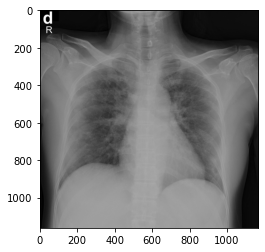

In [3]:
#visualize and crop image in the training set


train_list = []
for image_path in glob.glob(train_img_dir + "/*"):
    img = Image.open(image_path)
    train_list.append(img)

fig = plt.figure()
plt.imshow(train_list[5], cmap = "gray")

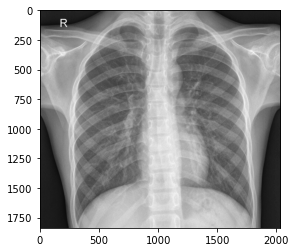

In [4]:
#Visualize an image in the test set
test_list = []
for image_path in glob.glob(test_img_dir + "/*"):
    img = Image.open(image_path)
    test_list.append(img)
    
fig = plt.figure()
plt.imshow(test_list[2], cmap = "gray")

In [5]:
print("There are " + str(len(test_list)) + " images in the test set")
print("There are " + str(len(train_list)) + " images in the training set")

There are 624 images in the test set
There are 5309 images in the training set


In [6]:
# Information about data set
df_metadata = pd.read_csv("coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv")
df_metadata.head()

#Label column is the target column for prediction 

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [7]:
set(df_metadata["Label"])  # two label: binary classification

{'Normal', 'Pnemonia'}

In [8]:
#divide train & test metadata
train_df = df_metadata[df_metadata["Dataset_type"] == "TRAIN"]
test_df = df_metadata[df_metadata["Dataset_type"] == "TEST"]

train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


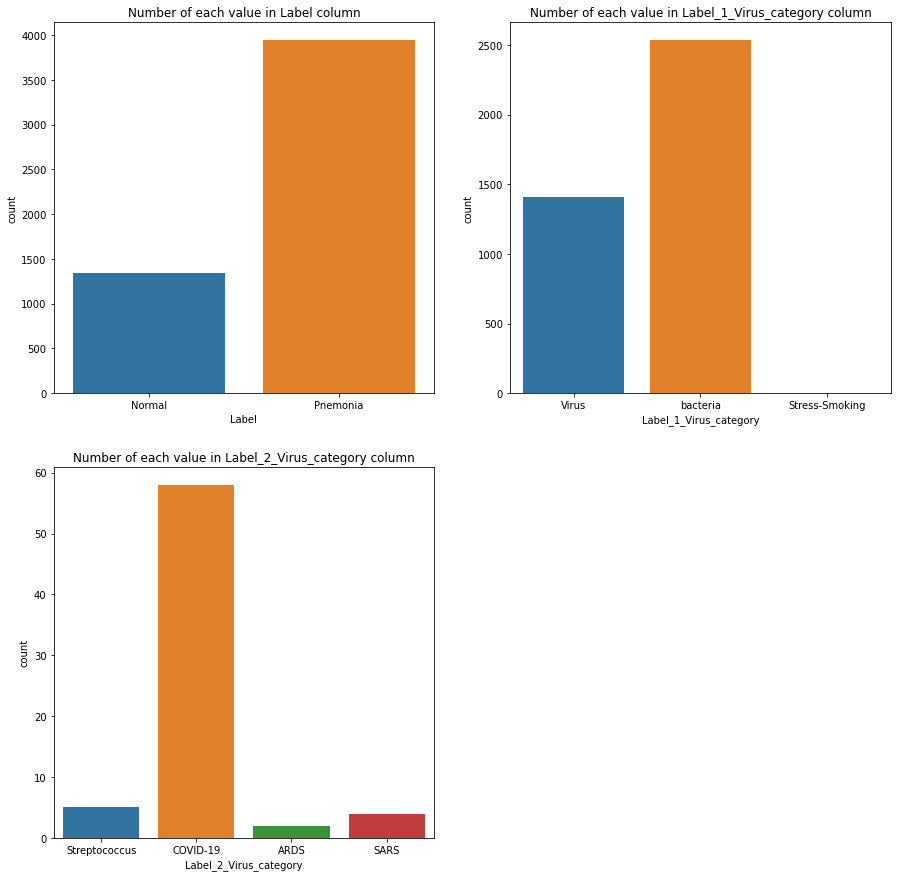

In [9]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

fig = plt.figure(figsize=(15, 15))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x = col[i], data = train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
plt.show()


In [10]:
print("Data for Normal and Pnemonia cases are imbalanced, also Label_2_virus and Label_1_virus categories are imbalanced")

Data for Normal and Pnemonia cases are imbalanced, also Label_2_virus and Label_1_virus categories are imbalanced


In [11]:
# Convert Nan cases to "unknown"

train_df.fillna("unknown", inplace = True )
test_df.fillna("unknown", inplace = True )

C:\Users\nuras\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [12]:
train_df["Label_2_Virus_category"].value_counts()


unknown          5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64

In [13]:
train_df["Label_1_Virus_category"].value_counts()

bacteria          2535
Virus             1407
unknown           1342
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [14]:
# Shuflle train_df  to mix the rows to randomize splitting

train_df = train_df.iloc[np.random.permutation(len(train_df))]

train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
2765,2765,person1669_bacteria_4422.jpeg,Pnemonia,TRAIN,unknown,bacteria
4759,4759,person877_bacteria_2800.jpeg,Pnemonia,TRAIN,unknown,bacteria
3598,3598,person336_bacteria_1552.jpeg,Pnemonia,TRAIN,unknown,bacteria
4381,4381,person543_bacteria_2283.jpeg,Pnemonia,TRAIN,unknown,bacteria
4068,4068,person480_virus_981.jpeg,Pnemonia,TRAIN,unknown,Virus


In [15]:
# Take 15% of training data as validation data

valid_df = train_df[0:round(0.15*len(train_df))]   
train_df = train_df[len(valid_df):]

valid_df.shape, train_df.shape

((793, 6), (4493, 6))

In [16]:
# Function creates working directories for labelled images

def create_dir():   
    try:
        os.makedirs('working/train/Pnemonia')
        os.makedirs('working/train/Normal')
        os.makedirs('working/valid/Pnemonia')
        os.makedirs('working/valid/Normal')
        os.makedirs('working/test/Pnemonia')
        os.makedirs('working/test/Normal')
    except:
        pass

In [17]:
create_dir()  # call function

In [18]:
# Move training data with labels Pnemonia and Normal to created directiories

#COVID-19 case
train_pnemonia ='working/train/Pnemonia'
move_train_pnemonia = train_df[train_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_train_pnemonia:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_pnemonia)
    
#Normal cases 
train_normal =  'working/train/Normal'
move_train_normal = train_df[train_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_train_normal:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_normal)
    
    
#COVID-19 case
valid_pnemonia ='working/valid/Pnemonia'
move_valid_pnemonia = valid_df[valid_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_valid_pnemonia:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, valid_pnemonia)
    
#Normal cases 
valid_normal =  'working/valid/Normal'
move_valid_normal = valid_df[valid_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_valid_normal:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, valid_normal)
    

In [19]:
# Move test data with labels Pnemonia and Normal to created directiories


#COVID-19 cases
test_pnemonia = 'working/test/Pnemonia'
move_test_pnemonia = test_df[test_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_test_pnemonia :
    path = os.path.join(test_img_dir,i)
    shutil.copy(path,test_pnemonia)

#Normal cases
test_normal = 'working/test/Normal'
move_test_normal = test_df[test_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_test_normal:
    path = os.path.join(test_img_dir,i)
    shutil.copy(path, test_normal)

In [20]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 224,224,3
epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [21]:
#Data Augmentation on the training set

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   rotation_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode ='nearest')

train_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

valid_datagen = ImageDataGenerator(rescale = 1.255)

valid_generator = valid_datagen.flow_from_directory('working/valid/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('working/test/',
                                                  target_size = (224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='binary')




Found 4493 images belonging to 2 classes.
Found 793 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [31]:
#Modelling, Transfer Learning 

# include_top = False, we eliminate the fully connected layers of ResNet architecture, instead
# we add to the structure a fully connected layer for prediction

base_model = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet",
                                           input_shape = input_shape)

base_model.trainable = False # do not update pre-trained weights of the base_model during training

model = models.Sequential()
model.add(base_model)
model.add(layers.Dropout(0.3))
model.add(GlobalAveragePooling2D())
#model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
____________________________________

In [32]:

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0,  name="SGD")

model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data = valid_generator,  epochs = epochs) 

model.save("tl_model.h5")

Epoch 1/15
141/141 [==============================] - 516s 4s/step - loss: 0.7364 - accuracy: 0.6845 - val_loss: 0.6996 - val_accuracy: 0.5624
Epoch 2/15
141/141 [==============================] - 554s 4s/step - loss: 0.5886 - accuracy: 0.7355 - val_loss: 0.6527 - val_accuracy: 0.7125
Epoch 3/15
141/141 [==============================] - 531s 4s/step - loss: 0.5499 - accuracy: 0.7619 - val_loss: 0.6528 - val_accuracy: 0.7125
Epoch 4/15
141/141 [==============================] - 513s 4s/step - loss: 0.5656 - accuracy: 0.7472 - val_loss: 0.6543 - val_accuracy: 0.7074
Epoch 5/15
141/141 [==============================] - 495s 4s/step - loss: 0.5572 - accuracy: 0.7552 - val_loss: 0.6549 - val_accuracy: 0.7049
Epoch 6/15
141/141 [==============================] - 492s 3s/step - loss: 0.5705 - accuracy: 0.7426 - val_loss: 0.6485 - val_accuracy: 0.7226
Epoch 7/15
141/141 [==============================] - 492s 3s/step - loss: 0.5762 - accuracy: 0.7374 - val_loss: 0.6510 - val_accuracy: 0.7163

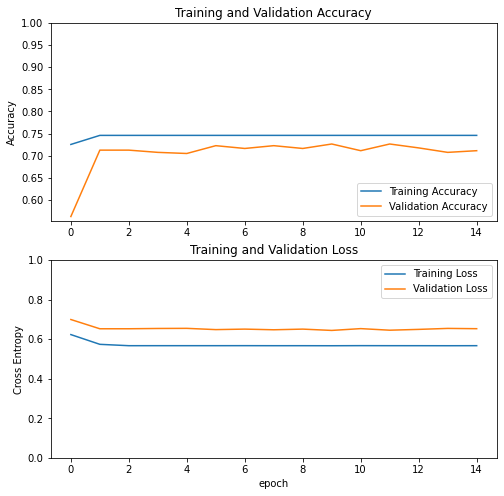

In [33]:
#learning curves druing fine-tuning stage
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
from tensorflow.keras.models import load_model

model = load_model("tl_model.h5")

In [68]:
# In order to improve model accuracy, we activate weights of pre-trained model during training with a lower learning rate, 
# and evaluate a few more epochs. This is called fine-tuning

fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
base_model.trainable = True


#add a earlystopping callback to stop the training if the model is not learning anymore
early_stopping = EarlyStopping (
min_delta = 0.001,
patience = 4,
restore_best_weights = True
)

#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
#optimizer = tf.keras.optimizers.SGD( learning_rate=0.0001, momentum=0.0,  name="SGD")

#model.compile(optimizer = optimizer,loss='binary_crossentropy',metrics=['accuracy'])

optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.1)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine_tune = model.fit(train_generator, validation_data = valid_generator,  epochs = total_epochs,  initial_epoch=history.epoch[-1], callbacks = [early_stopping])




Epoch 15/25
141/141 [==============================] - 564s 4s/step - loss: 0.5841 - accuracy: 0.7330 - val_loss: 0.6416 - val_accuracy: 0.7364
Epoch 16/25
141/141 [==============================] - 513s 4s/step - loss: 0.5592 - accuracy: 0.7543 - val_loss: 0.6496 - val_accuracy: 0.7188
Epoch 17/25
141/141 [==============================] - 509s 4s/step - loss: 0.5591 - accuracy: 0.7547 - val_loss: 0.6325 - val_accuracy: 0.7402
Epoch 18/25
141/141 [==============================] - 509s 4s/step - loss: 0.5816 - accuracy: 0.7461 - val_loss: 0.6345 - val_accuracy: 0.7402
Epoch 19/25
141/141 [==============================] - 504s 4s/step - loss: 0.5748 - accuracy: 0.7416 - val_loss: 0.6540 - val_accuracy: 0.7112
Epoch 20/25
141/141 [==============================] - 516s 4s/step - loss: 0.5730 - accuracy: 0.7416 - val_loss: 0.6476 - val_accuracy: 0.7226
Epoch 21/25
141/141 [==============================] - 505s 4s/step - loss: 0.5634 - accuracy: 0.7487 - val_loss: 0.6477 - val_accuracy:

In [62]:
model.save("fine_tuned_model.h5") 

In [63]:
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

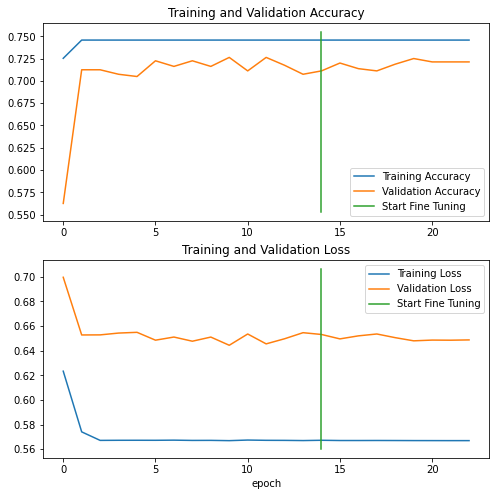

In [64]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.plot([epochs-1, epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
 #make predictions on test data, from classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred = model.predict(test_generator)
y_pred = (pred >= 0.5).astype('int')
y_test = test_generator.labels

print('Classification report:\n', classification_report(y_test, y_pred))
print('Accuracy score:\n', accuracy_score(y_test, y_pred))


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

Accuracy score:
 0.625


In [69]:
model.evaluate(test_generator)

20/20 [==============================] - 57s 3s/step - loss: 0.7268 - accuracy: 0.6250


[0.7267552018165588, 0.625]

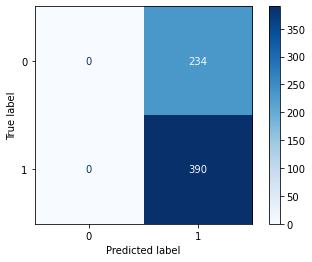

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

